This file helps 
1. converts the ffmepge records to csv
2. do regression based on existing data

In [1]:
import csv

# converts ff_records.txt into csv
fp = open("ff_records.txt", "r")
fp_csv = open("ff_records.csv", "a")
csv_write = csv.writer(fp_csv)
csv_write.writerow(["BER", "IBER", "NIBER", "PSNR", "SSIM"])
index = 0
row = []
for line in fp.readlines():
    index += 1
    if(index % 11 == 1): # bit error rate
        ber = float(line.split(" ")[-1])
        row.append(ber)
    elif(index % 11 == 2):
        Iber = float(line.split(" ")[-1])
        row.append(Iber)
    elif(index % 11 == 3):
        NIber = float(line.split(" ")[-1])
        row.append(NIber)
    elif(index % 11 == 9):
        psnr = float(line.split(" ")[-1])
        row.append(psnr)
    elif(index % 11 == 10):
        ssim = float(line.split(" ")[-1])        
        row.append(ssim)
        csv_write.writerow(row)
    elif (index % 11 == 0):
        row = []
fp.close()
fp_csv.close()
print("Executed!")

Executed!


In [52]:
# combine and average the data row with the same IBER and NIBER
fp_csv = open("ff_records.csv", "r")
fp_ext = open("ff_records_final.csv", "a")
csv_read = csv.reader(fp_csv)
csv_write = csv.writer(fp_ext)
csv_write.writerow(["IBER", "NIBER", "PSNR", "SSIM"])
firstline = 1
size = 0
group = 100
dic = {}
for row in csv_read:
    if firstline:
        firstline = 0
        continue
    size += 1
    if(size % group == 1 and size != 1):
        for it_key, it_value in dic.items():
            iber = float(it_key.split("|")[0])
            niber = float(it_key.split("|")[1])
            length = len(it_value)
            count = 0
            psnr_avg = 0
            ssim_avg = 0
            while count < length:
                if count % 2 == 0:
                    psnr_avg += float(it_value[count])
                else:
                    ssim_avg += float(it_value[count])
                count += 1
            psnr_avg /= (length/2)
            ssim_avg /= (length/2)
            psnr_avg = round(psnr_avg, 6)
            ssim_avg = round(ssim_avg, 6)
            if(iber != 0 and niber !=0):
                csv_write.writerow([iber, niber, psnr_avg, ssim_avg])
        dic.clear()
    key = str(row[1]) + str("|") + str(row[2])
    value = []
    value.append(row[3])
    value.append(row[4])
    if key in dic:
        dic[key] = dic[key] + value
        # print(dic[key])
    else:
        dic[key] = value
for it_key, it_value in dic.items():
    iber = float(it_key.split("|")[0])
    niber = float(it_key.split("|")[1])
    length = len(it_value)
    count = 0
    psnr_avg = 0
    ssim_avg = 0
    while count < length:
        if count % 2 == 0:
            psnr_avg += float(it_value[count])
        else:
            ssim_avg += float(it_value[count])
        count += 1
    psnr_avg /= (length/2)
    ssim_avg /= (length/2)
    psnr_avg = round(psnr_avg, 6)
    ssim_avg = round(ssim_avg, 6)
    csv_write.writerow([iber, niber, psnr_avg, ssim_avg])    
# print(dic)
fp_csv.close()
fp_ext.close()
print("Executed!")

Executed!


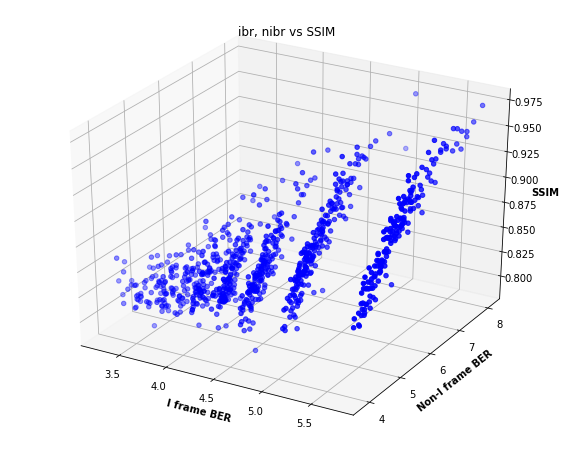

In [13]:
# data preparations
# TODO: uni-variant regression and visualization
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import math

stat = pd.read_csv("ff_records_final.csv")
stat.columns = ['ibr','nibr','psnr','ssim']
stat_arr = np.array(stat)
ibr = stat_arr[...,0]
nibr = stat_arr[..., 1]
BR = stat_arr[...,0:2]
psnr = stat_arr[..., 2]
ssim = stat_arr[..., 3]
ibr_log = [-math.log(x) for x in ibr]
nibr_log = [-math.log(x) for x in nibr]
BR_log = [[-math.log(x[0]), -math.log(x[1])] for x in BR]

# label_title = "test"
# plt.scatter(ibr_power, psnr, label = label_title, marker=".")
# plt.xlabel("non I frame bit error rate lnx")
# plt.ylabel("PSNR")
# plt.show()
# plt.savefig("./charts/IberPSNR.png",format="png")
# plt.scatter(ibr_power, ssim, marker='.')
# plt.xlabel("non I frame bit error rate lnx")
# plt.ylabel("SSIM")
# plt.show()
# plt.savefig("./charts/iberSSIM.png",format="png")
# print(BR[0])


# creating figure
# fig = plt.figure(figsize=(10, 8))
# ax = plt.axes(projection="3d")
# creating plot
# ax.scatter3D(ibr_log, nibr_log, psnr, color = "blue")
# plt.title("ibr, nibr vs PSNR")
# ax.set_xlabel("I frame BER", fontweight="bold")
# ax.set_ylabel("Non-I frame BER", fontweight="bold")
# ax.set_zlabel("PSNR", fontweight="bold")
# plt.savefig("./charts/berPSNR3d.png", format="png")
# plt.show()

# creating figure
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.scatter3D(ibr_log, nibr_log, ssim, color = "blue")
plt.title("ibr, nibr vs SSIM")
ax.set_xlabel("I frame BER", fontweight="bold")
ax.set_ylabel("Non-I frame BER", fontweight="bold")
ax.set_zlabel("SSIM", fontweight="bold")
plt.savefig("./charts/berSSIM3d.png", format="png")
# plt.show()

In [14]:
# multi-variant Linear regression
# TODO a 3-d visualization
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(BR_log, psnr)
r2_score = model.score(BR_log, psnr)
print("PSNR--------------------")
print("R2 score is:", r2_score)
print('coefficient of determination:', model.coef_)
print("interception is:", model.intercept_)
print("SSIM--------------------")
model.fit(BR_log, ssim)
r2_score = model.score(BR_log, ssim)
print("R2 score is:", r2_score)
print('coefficient of determination:', model.coef_)
print("interception is:", model.intercept_)


PSNR--------------------
R2 score is: 0.6583438978562287
coefficient of determination: [1.01754693 2.02190016]
interception is: 9.330120339849236
SSIM--------------------
R2 score is: 0.847488470055265
coefficient of determination: [0.01428171 0.03671935]
interception is: 0.6298459840644551
